# Abstract

Kaggle dataset: https://www.kaggle.com/brandao/diabetes


We picked a publicly available dataset from UCI repository containing de-identified diabetes patient encounter data for 130 US hospitals (1999–2008) containing 101,766 observations over 10 years. The dataset has over 50 features including patient characteristics, conditions, tests and 23 medications. Only diabetic encounters are included (i.e. at least one of three primary diagnosis was diabetes).

Applied methods are:
* Cleaning tasks such as dropping bad data, dealing with missing values.
* Modification of existing features e.g. standardization, log transforms etc.
* Creation or derivation of new features, usually from existing ones.
* Graphs such as plots, heatmap have been used.



## Overview of Dataset

### Starting H2O server¶

In [1]:
# import h2o package and specific estimator 

import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import seaborn
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

### Required Data Parameters

* y: This argument is the name (or index) of the response column.
* training_frame: Specifies the training set.

### Required Stopping Parameters

* max_runtime_secs: This argument controls how long the AutoML run will execute for. This defaults to 3600 seconds (1 hour).
* max_models: Specify the maximum number of models to build in an AutoML run, excluding the Stacked Ensemble models. Defaults to NULL/None.


In [2]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

5


In [3]:
# 65535 Highest port no
port_no=random.randint(5555,55555)

 # start h2o
h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o


Checking whether there is an H2O instance running at http://localhost:24433..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)56-b12)
  Starting server from C:\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\joiss\AppData\Local\Temp\tmpjt5umsln
  JVM stdout: C:\Users\joiss\AppData\Local\Temp\tmpjt5umsln\h2o_joiss_started_from_python.out
  JVM stderr: C:\Users\joiss\AppData\Local\Temp\tmpjt5umsln\h2o_joiss_started_from_python.err
  Server is running at http://127.0.0.1:24433
Connecting to H2O server at http://127.0.0.1:24433... successful.


H2O cluster uptime:,04 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.3
H2O cluster version age:,2 months and 21 days
H2O cluster name:,H2O_from_python_joiss_x0l8rr
H2O cluster total nodes:,1
H2O cluster free memory:,4.792 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


## Data overview

In [4]:
# Import data and manage data types
train_path = "Dataset/diabetes_train.csv"
df = h2o.import_file(train_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [5]:
df.head(5)

id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
2.27839e+06,8.22216e+06,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,nan,nan,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
64410,8.60479e+07,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,nan,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
500364,8.24424e+07,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
16680,4.25193e+07,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
55842,8.42598e+07,Caucasian,Male,[60-70),?,3,1,2,4,?,?,70,1,21,0,0,0,414,411,nan,7,None,None,Steady,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [6]:
df.tail(5)

id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
2.40242e+08,4.57489e+07,Caucasian,Male,[60-70),?,3,1,1,6,?,?,62,6,50,0,0,0,414,411,427,8,None,None,No,No,No,No,No,No,No,Steady,No,Steady,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,NO
2.40251e+08,6.05036e+07,AfricanAmerican,Male,[20-30),?,1,1,7,3,OG,?,60,0,9,0,0,1,250.12,276,276,7,None,Norm,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,<30
2.40257e+08,2.18105e+06,Caucasian,Female,[70-80),?,3,6,1,3,?,?,26,2,32,0,0,0,715,285,278,9,None,None,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
2.40257e+08,4.61461e+07,Caucasian,Male,[60-70),?,3,1,1,1,MC,?,34,1,21,0,0,0,414,428,276,9,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
2.40277e+08,3.42898e+07,Caucasian,Female,[60-70),?,1,1,7,1,BC,?,50,6,25,0,0,0,414,428,411,9,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [7]:
df.describe()

Rows:50001
Cols:50




,id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
type,int,int,enum,enum,enum,enum,int,int,int,int,enum,enum,int,int,int,int,int,int,real,real,real,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum
mins,12522.0,135.0,,,,,1.0,1.0,1.0,1.0,,,1.0,0.0,1.0,0.0,0.0,0.0,3.0,8.0,5.0,1.0,,,,,,,,,,,,,,,,,,,,,,,,,,,,
mean,118350344.8944621,43491484.558948815,,,,,2.102177956440871,4.167336653266933,5.74982500349993,4.4368312633747315,,,42.90460190796182,1.385032299354013,15.681846363072736,0.25887482250355004,0.13165736685266294,0.523189536209276,493.62482470614606,432.29717529593415,412.4333165829146,7.069218615627688,,,,,,,,,,,,,,,,,,,,,,,,,,,,
maxs,240277404.0,115218477.0,,,,,8.0,28.0,22.0,14.0,,,132.0,6.0,81.0,36.0,28.0,21.0,999.0,999.0,999.0,9.0,,,,,,,,,,,,,,,,,,,,,,,,,,,,
sigma,60444491.42445576,35065949.89381691,,,,,1.4867613986147448,5.808736341446589,4.316877484869778,3.0317477848441454,,,19.066150608395485,1.6987840249592443,8.459927673383218,0.9949384332461385,0.636463660455315,1.156783140720553,208.26118899894746,180.2259649013558,177.02506045996856,2.02268848007454,,,,,,,,,,,,,,,,,,,,,,,,,,,,
zeros,0,0,,,,,0,0,0,0,,,0,21844,0,43811,45948,35748,0,0,0,0,,,,,,,,,,,,,,,,,,,,,,,,,,,,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,912,1426,3435,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,2278392.0,8222157.0,Caucasian,Female,[0-10),?,6.0,25.0,1.0,1.0,?,Pediatrics-Endocrinology,41.0,0.0,1.0,0.0,0.0,0.0,250.83,nan,nan,1.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,64410.0,86047875.0,AfricanAmerican,Female,[20-30),?,1.0,1.0,7.0,2.0,?,?,11.0,5.0,13.0,2.0,0.0,1.0,648.0,250.0,nan,6.0,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
2,500364.0,82442376.0,Caucasian,Male,[30-40),?,1.0,1.0,7.0,2.0,?,?,44.0,1.0,16.0,0.0,0.0,0.0,8.0,250.43,403.0,7.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO


In [8]:

# assign target and inputs
y = "readmitted"
X = [name for name in df.columns if name != y]
print("y: ",y)
print("X: ", X)

y:  readmitted
X:  ['id', 'patient_nbr', 'race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']


In [9]:
# determine column types
ints, reals, enums = [], [], []
for key, val in df.types.items():
    if key in X:
        if val == 'enum':
            enums.append(key)
        elif val == 'int':
            ints.append(key)            
        else: 
            reals.append(key)

print("Integer columns:",ints,"\n")
print("Enum columns:", enums, "\n")
print("Real numbers: ",reals, "\n")

Integer columns: ['id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses'] 

Enum columns: ['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed'] 

Real numbers:  ['diag_1', 'diag_2', 'diag_3'] 



# Feature Engineering


In [10]:
print('Number of samples:', df.shape)

Number of samples: (50001, 50)


* Since, admission_type_id', 'discharge_disposition_id', 'admission_source_id' are multi-class columns and are more of Ids ie, enum than integres, we are converting them into "enums". 

* Also, diag_1, diag_2, diag_3 are enum and not suited to be real numbers 

In [11]:
#Convert to enums

for j in ["admission_type_id", "discharge_disposition_id", "admission_source_id",
          "diag_1", "diag_2", "diag_3"]:
    df[j] = (df[j].ascharacter()).asfactor()
df = h2o.assign(df, "diabetes_train")

In [12]:
# determine column types
ints, reals, enums = [], [], []
for key, val in df.types.items():
    if key in X:
        if val == 'enum':
            enums.append(key)
        elif val == 'int':
            ints.append(key)            
        else: 
            reals.append(key)

print("Integer columns:",ints,"\n")
print("Enum columns:", enums, "\n")
print("Real numbers: ",reals, "\n")

Integer columns: ['id', 'patient_nbr', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses'] 

Enum columns: ['race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed'] 

Real numbers:  [] 



In [13]:
df["readmitted"].head()

readmitted
NO
NO
NO
NO
NO
NO
NO
<30
<30
NO


In [14]:
df["readmitted"].nlevels()

[2]

In [15]:
df["readmitted"].categories()

['<30', 'NO']

In [16]:
#one-hot encoding: 0 if No, 1 is <30 days 
df["readmitted"]=df["readmitted"].set_levels(["1","0"])

In [17]:
df["readmitted"].categories()

['1', '0']

In [18]:
# Set target and predictor variables
y = "readmitted"
x = df.col_names
x.remove(y)
x.remove("id")
x.remove("patient_nbr")

In [19]:
predictors=df[x]
type(predictors)

h2o.frame.H2OFrame

In [20]:
response=y

In [21]:
type(df["readmitted"])

h2o.frame.H2OFrame

In [22]:
df["readmitted"].head(3)

readmitted
0
0
0


In [23]:
x1= df[ints]

In [24]:
x1.columns

['id',
 'patient_nbr',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses']

In [25]:
x1=x1.drop("patient_nbr")

In [26]:
x1=x1.drop("id")


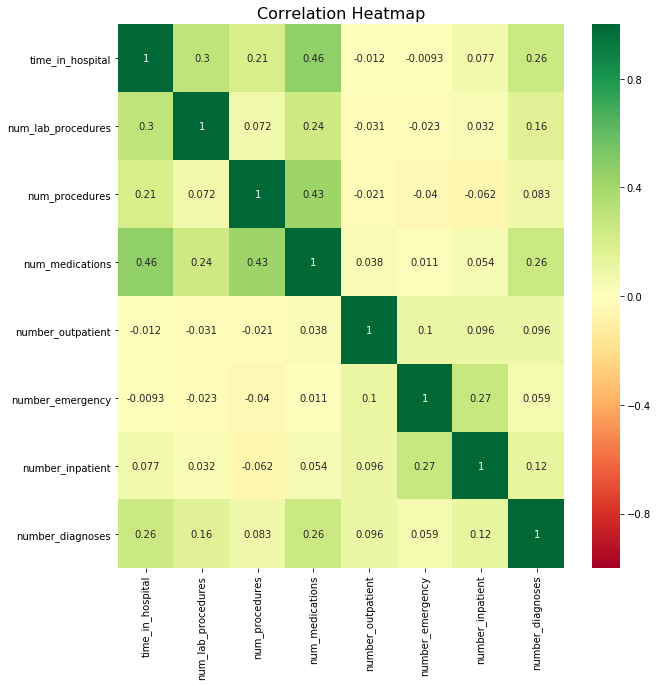

In [27]:
plt.figure(figsize=(10,10))
corr = x1.cor().as_data_frame()
corr.index = x1.columns
sns.heatmap(corr, annot = True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

In [28]:
## Variable importance using XGB

In [29]:
# train['readmitted'].isnull().sum()

In [30]:
#from h2o.estimators import H2OXGBoostEstimator

#cv_xgb = H2OXGBoostEstimator(
  #  ntrees = 3000,
   # learn_rate = 0.05,
    #stopping_rounds = 20,
    #stopping_metric = "AUC",
    #nfolds=4, 
    #seed=2018)
#cv_xgb.train(x = predictors, y = response, training_frame = train)
#cv_xgb.model_performance(valid).auc()

## Meta data

In [31]:
data_path=None
all_variables=None
test_path=None
# target='search_term'
target=y
nthreads=1 
min_mem_size=6 
run_time=500
classification=True
scale=False
max_models=9    
model_path=None
balance_y=False 
balance_threshold=0.2
name=None 
server_path=None  
analysis=0

In [32]:
def set_meta_data(analysis,run_id,server,data,test,model_path,target,run_time,classification,scale,model,balance,balance_threshold,name,path,nthreads,min_mem_size):
    m_data={}
    m_data['start_time'] = time.time()
    m_data['target']=target
    m_data['server_path']=server
    m_data['data_path']=data 
    m_data['test_path']=test
    m_data['max_models']=model
    m_data['run_time']=run_time
    m_data['run_id'] =run_id
    m_data['scale']=scale
    m_data['classification']=classification
    m_data['scale']=False
    m_data['model_path']=model_path
    m_data['balance']=balance
    m_data['balance_threshold']=balance_threshold
    m_data['project'] =name
    m_data['end_time'] = time.time()
    m_data['execution_time'] = 0.0
    m_data['run_path'] =path
    m_data['nthreads'] = nthreads
    m_data['min_mem_size'] = min_mem_size
    m_data['analysis'] = analysis
    return m_data


In [33]:
def dict_to_json(dct,n):
    j = json.dumps(dct, indent=4)
    f = open(n, 'w')
    print(j, file=f)
    f.close()

In [34]:
run_id="DS01_HyperParameter"
if server_path==None:
    server_path=os.path.abspath(os.curdir)
os.chdir(server_path) 
run_dir = os.path.join(server_path,run_id)
#os.mkdir(run_dir)
os.chdir(run_dir)    

# run_id to std out
print ("Run id:", run_id)
print ("Run dir:", run_dir)

Run id: DS01_HyperParameter
Run dir: C:\Users\joiss\Desktop\NEU-MSIS\2_Sem2\INFO6105_Data_Science_Engineering_Methods\DS01_Hyperparameter\DS01_HyperParameter


In [35]:
# meta data
meta_data = set_meta_data(analysis, run_id,server_path,data_path,test_path,model_path,target,run_time,classification,scale,max_models,balance_y,balance_threshold,name,run_dir,nthreads,min_mem_size)
print(meta_data)

{'start_time': 1555443883.7061415, 'target': 'readmitted', 'server_path': 'C:\\Users\\joiss\\Desktop\\NEU-MSIS\\2_Sem2\\INFO6105_Data_Science_Engineering_Methods\\DS01_Hyperparameter', 'data_path': None, 'test_path': None, 'max_models': 9, 'run_time': 500, 'run_id': 'DS01_HyperParameter', 'scale': False, 'classification': True, 'model_path': None, 'balance': False, 'balance_threshold': 0.2, 'project': None, 'end_time': 1555443883.7061415, 'execution_time': 0.0, 'run_path': 'C:\\Users\\joiss\\Desktop\\NEU-MSIS\\2_Sem2\\INFO6105_Data_Science_Engineering_Methods\\DS01_Hyperparameter\\DS01_HyperParameter', 'nthreads': 1, 'min_mem_size': 6, 'analysis': 0}


In [36]:
meta_data_startTime_beforeModelEval= time.asctime(time.localtime(meta_data["start_time"])) 
print("meta_data_startTime_beforeModelEval: ",meta_data_startTime_beforeModelEval)

meta_data_startTime_beforeModelEval:  Tue Apr 16 15:44:43 2019


In [37]:
meta_data_endTime_beforeModelEval= time.asctime( time.localtime(meta_data["end_time"]) )
print( "meta_data_endTime_beforeModelEval= ", meta_data_endTime_beforeModelEval)

meta_data_endTime_beforeModelEval=  Tue Apr 16 15:44:43 2019


In [38]:
# Add independent variables

meta_data['X']=x1.columns 

In [39]:
meta_data['variables']=df.columns

In [40]:
type(x1)
independentVars_df=x1.as_data_frame()

In [41]:
# save the changed dataset
dataset_stats=run_id+'_independentVariables.csv'
independentVars_df.to_csv(dataset_stats, index=False)

## Train model using h2o

In [42]:
# Split the data into Train/Test/Validation with Train having 70% and test and validation 15% each
#train, valid, test = df.split_frame(ratios=[0.7, 0.15], seed=42)

In [43]:
# Use Auto ML to train models
from h2o.automl import H2OAutoML
aml = H2OAutoML(max_runtime_secs = run_time,project_name = name)


In [44]:
model_start_time = time.time()

In [45]:
########### Uncomment this if we have to split data in to train, test, and valid #########
#aml.train(x = x1.columns, y = y, training_frame = train)

In [46]:
aml.train(x = x1.columns, y = y, training_frame = df)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [47]:
meta_data['model_execution_time'] = time.time() - model_start_time

## Print Leaderboard

In [48]:
aml.leaderboard

model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_20190416_154445_model_9,0.689646,0.429881,0.473879,0.365185,0.13336
StackedEnsemble_AllModels_AutoML_20190416_154445,0.689616,0.430082,0.469896,0.365186,0.133361
StackedEnsemble_BestOfFamily_AutoML_20190416_154445,0.688624,0.430669,0.465692,0.365407,0.133522
GBM_grid_1_AutoML_20190416_154445_model_5,0.687819,0.430207,0.471858,0.365249,0.133407
GBM_1_AutoML_20190416_154445,0.687817,0.430465,0.474701,0.365519,0.133604
GBM_grid_1_AutoML_20190416_154445_model_1,0.68748,0.430199,0.469463,0.365236,0.133397
GBM_grid_1_AutoML_20190416_154445_model_7,0.687317,0.431156,0.473674,0.365673,0.133717
GBM_2_AutoML_20190416_154445,0.686721,0.430653,0.47114,0.365536,0.133617
GBM_grid_1_AutoML_20190416_154445_model_2,0.686113,0.430836,0.471662,0.365589,0.133655
GBM_grid_1_AutoML_20190416_154445_model_10,0.685963,0.454797,0.470467,0.376829,0.142


In [99]:
aml.leader

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid_1_AutoML_20190416_154445_model_9


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.13048581283140012
RMSE: 0.36122820049298493
LogLoss: 0.422135464445845
Mean Per-Class Error: 0.3522530508862758
AUC: 0.706637380194801
pr_auc: 0.9065442267789979
Gini: 0.4132747603896021
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5399938347858725: 


,1,0,Error,Rate
1,927.0,7947.0,0.8955,(7947.0/8874.0)
0,407.0,40720.0,0.0099,(407.0/41127.0)
Total,1334.0,48667.0,0.1671,(8354.0/50001.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5399938,0.9069648,309.0
max f2,0.3128464,0.9593708,368.0
max f0point5,0.6922283,0.8707709,234.0
max accuracy,0.5520656,0.8329233,305.0
max precision,0.9419345,1.0,0.0
max recall,0.2229908,1.0,385.0
max specificity,0.9419345,1.0,0.0
max absolute_mcc,0.6922283,0.2610469,234.0
max min_per_class_accuracy,0.8375744,0.6466081,116.0
max mean_per_class_accuracy,0.8383178,0.6477469,115.0


Gains/Lift Table: Avg response rate: 82.25 %, avg score: 82.26 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100198,0.9301205,1.1842237,1.1842237,0.9740519,0.9342672,0.9740519,0.9342672,0.0118657,0.0118657,18.4223718,18.4223718
,2,0.0201996,0.9261391,1.1679997,1.1760475,0.9607073,0.9277921,0.9673267,0.9310040,0.0118900,0.0237557,16.7999712,17.6047462
,3,0.0302994,0.9240315,1.1603989,1.1708313,0.9544554,0.9249597,0.9630363,0.9289892,0.0117198,0.0354755,16.0398929,17.0831284
,4,0.0400192,0.9221903,1.1432247,1.1641262,0.9403292,0.9230614,0.9575212,0.9275495,0.0111119,0.0465874,14.3224676,16.4126231
,5,0.0500590,0.9202394,1.1406932,1.1594265,0.9382470,0.9211547,0.9536556,0.9262669,0.0114523,0.0580397,14.0693190,15.9426516
,6,0.1000180,0.9119317,1.1374123,1.1484304,0.9355484,0.9160936,0.9446111,0.9211853,0.0568240,0.1148637,13.7412344,14.8430435
,7,0.1500170,0.9040179,1.1243447,1.1404029,0.9248,0.9078988,0.9380083,0.9167571,0.0562161,0.1710798,12.4344708,14.0402930
,8,0.2000160,0.8956203,1.1175364,1.1346869,0.9192,0.9000152,0.9333067,0.9125720,0.0558757,0.2269555,11.7536392,13.4686867
,9,0.3000140,0.8796925,1.0997861,1.1230541,0.9046,0.8879192,0.9237384,0.9043550,0.1099764,0.3369319,9.9786140,12.3054067
,10,0.4000320,0.8662190,1.0686918,1.1094621,0.8790242,0.8724027,0.9125587,0.8963661,0.1068884,0.4438204,6.8691827,10.9462148




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.13336001122934005
RMSE: 0.3651849000565878
LogLoss: 0.42988057085385384
Mean Per-Class Error: 0.3639354403014867
AUC: 0.6896461618619313
pr_auc: 0.8988503280245042
Gini: 0.37929232372386257
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4504743198778146: 


,1,0,Error,Rate
1,513.0,8361.0,0.9422,(8361.0/8874.0)
0,229.0,40898.0,0.0056,(229.0/41127.0)
Total,742.0,49259.0,0.1718,(8590.0/50001.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4504743,0.9049632,336.0
max f2,0.2406280,0.9587894,383.0
max f0point5,0.6887853,0.8669088,233.0
max accuracy,0.4972369,0.8284834,323.0
max precision,0.9436351,1.0,0.0
max recall,0.1380355,1.0,396.0
max specificity,0.9436351,1.0,0.0
max absolute_mcc,0.7527218,0.2395214,195.0
max min_per_class_accuracy,0.8379620,0.6334235,117.0
max mean_per_class_accuracy,0.8349883,0.6360646,121.0


Gains/Lift Table: Avg response rate: 82.25 %, avg score: 82.26 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100198,0.9306827,1.1672369,1.1672369,0.9600798,0.9347081,0.9600798,0.9347081,0.0116955,0.0116955,16.7236903,16.7236903
,2,0.0200196,0.9266678,1.1501190,1.1586865,0.946,0.9285177,0.9530470,0.9316160,0.0115010,0.0231964,15.0119046,15.8686525
,3,0.0300794,0.9242798,1.1166721,1.1446351,0.9184891,0.9253504,0.9414894,0.9295205,0.0112335,0.0344299,11.6672059,14.4635144
,4,0.0400192,0.9224346,1.1228144,1.1392154,0.9235412,0.9233133,0.9370315,0.9279788,0.0111606,0.0455905,12.2814353,13.9215388
,5,0.0500190,0.9205488,1.1501190,1.1413952,0.946,0.9214636,0.9388245,0.9266763,0.0115010,0.0570914,15.0119046,14.1395247
,6,0.1000780,0.9124155,1.1297973,1.1355939,0.9292849,0.9164356,0.9340528,0.9215539,0.0565565,0.1136480,12.9797267,13.5593939
,7,0.1500170,0.9045005,1.1179053,1.1297056,0.9195034,0.9084233,0.9292094,0.9171829,0.0558271,0.1694750,11.7905262,12.9705574
,8,0.2000160,0.8962337,1.1155912,1.1261773,0.9176,0.9003683,0.9263074,0.9129797,0.0557784,0.2252535,11.5591159,12.6177323
,9,0.3000140,0.8803805,1.0905463,1.1143011,0.897,0.8884289,0.9165389,0.9047966,0.1090524,0.3343059,9.0546283,11.4301102
,10,0.4000120,0.8660042,1.0657446,1.1021626,0.8766,0.8730388,0.9065547,0.8968575,0.1065723,0.4408783,6.5744562,10.2162574



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.8290234,0.0026222,0.830017,0.8234,0.8332,0.8323,0.8262
auc,0.6898131,0.0035920,0.6839782,0.6930985,0.6842226,0.6907362,0.6970298
err,0.1709766,0.0026222,0.169983,0.1766,0.1668,0.1677,0.1738
err_count,1709.8,26.216026,1700.0,1766.0,1668.0,1677.0,1738.0
f0point5,0.8598012,0.0023811,0.8595649,0.8549861,0.8633615,0.8636827,0.8574108
f1,0.9052132,0.0015395,0.9061085,0.9019325,0.9079166,0.9065998,0.9035088
f2,0.9556972,0.0011532,0.9579811,0.9543339,0.9573204,0.9540052,0.9548452
lift_top_group,1.1700048,0.0232541,1.154189,1.1980441,1.1123364,1.190187,1.1952677
logloss,0.4298806,0.0028166,0.4290275,0.4368819,0.4253190,0.4271483,0.4310262
max_per_class_error,0.9290987,0.0121751,0.9444759,0.9379121,0.9367015,0.8958097,0.9305941


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-04-16 15:49:16,1 min 58.360 sec,0.0,0.3820714,0.4675453,0.5,0.0,1.0,0.1774765
,2019-04-16 15:49:16,1 min 58.436 sec,5.0,0.3752218,0.4513930,0.6913435,0.9002463,1.1406530,0.1696766
,2019-04-16 15:49:16,1 min 58.548 sec,10.0,0.3708318,0.4421788,0.6951109,0.8894722,1.1340970,0.1698566
,2019-04-16 15:49:17,1 min 58.673 sec,15.0,0.3679165,0.4362491,0.6969453,0.8990612,1.1486516,0.1690366
,2019-04-16 15:49:17,1 min 58.805 sec,20.0,0.3660381,0.4324215,0.6983979,0.9019050,1.1699789,0.1685566
,2019-04-16 15:49:17,1 min 58.927 sec,25.0,0.3646939,0.4296131,0.7002814,0.9027443,1.1672369,0.1683366
,2019-04-16 15:49:17,1 min 59.052 sec,30.0,0.3637240,0.4275524,0.7012926,0.9041849,1.1771748,0.1683166
,2019-04-16 15:49:17,1 min 59.158 sec,35.0,0.3629538,0.4259091,0.7022980,0.9047682,1.1720903,0.1677966
,2019-04-16 15:49:17,1 min 59.276 sec,40.0,0.3624149,0.4247401,0.7033333,0.9052121,1.1796587,0.1683966
,2019-04-16 15:49:17,1 min 59.399 sec,45.0,0.3619187,0.4236584,0.7044929,0.9057294,1.1866504,0.1681566


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
number_inpatient,4027.7858887,1.0,0.6491223
num_medications,365.4980469,0.0907442,0.0589041
number_emergency,364.9023132,0.0905963,0.0588080
number_diagnoses,363.5271301,0.0902548,0.0585864
time_in_hospital,363.0115662,0.0901268,0.0585033
num_lab_procedures,329.0525513,0.0816956,0.0530305
number_outpatient,206.6378479,0.0513031,0.0333020
num_procedures,184.5573120,0.0458210,0.0297435


In [106]:
a=aml.leaderboard

In [107]:
type(a)

h2o.frame.H2OFrame

In [121]:
a

model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_20190416_154445_model_9,0.689646,0.429881,0.473879,0.365185,0.13336
StackedEnsemble_AllModels_AutoML_20190416_154445,0.689616,0.430082,0.469896,0.365186,0.133361
StackedEnsemble_BestOfFamily_AutoML_20190416_154445,0.688624,0.430669,0.465692,0.365407,0.133522
GBM_grid_1_AutoML_20190416_154445_model_5,0.687819,0.430207,0.471858,0.365249,0.133407
GBM_1_AutoML_20190416_154445,0.687817,0.430465,0.474701,0.365519,0.133604
GBM_grid_1_AutoML_20190416_154445_model_1,0.68748,0.430199,0.469463,0.365236,0.133397
GBM_grid_1_AutoML_20190416_154445_model_7,0.687317,0.431156,0.473674,0.365673,0.133717
GBM_2_AutoML_20190416_154445,0.686721,0.430653,0.47114,0.365536,0.133617
GBM_grid_1_AutoML_20190416_154445_model_2,0.686113,0.430836,0.471662,0.365589,0.133655
GBM_grid_1_AutoML_20190416_154445_model_10,0.685963,0.454797,0.470467,0.376829,0.142


In [162]:
b=a.as_data_frame(use_pandas=False, header=True)

In [165]:
type(b)

list

In [166]:
b

[['model_id', 'auc', 'logloss', 'mean_per_class_error', 'rmse', 'mse'],
 ['GBM_grid_1_AutoML_20190416_154445_model_9',
  '0.6896461618619313',
  '0.42988057085385384',
  '0.4738793938195006',
  '0.3651849000565878',
  '0.13336001122934005'],
 ['StackedEnsemble_AllModels_AutoML_20190416_154445',
  '0.6896155846220039',
  '0.4300815397782149',
  '0.4698957859601206',
  '0.3651858014059971',
  '0.13336066954854037'],
 ['StackedEnsemble_BestOfFamily_AutoML_20190416_154445',
  '0.6886244554274262',
  '0.430668719893012',
  '0.46569241489196056',
  '0.365406920734831',
  '0.13352221772091105'],
 ['GBM_grid_1_AutoML_20190416_154445_model_5',
  '0.6878191419785629',
  '0.4302066286545963',
  '0.4718577819101646',
  '0.36524901539804727',
  '0.13340684324924296'],
 ['GBM_1_AutoML_20190416_154445',
  '0.6878171006645483',
  '0.430465128206495',
  '0.4747014159030769',
  '0.3655187222691048',
  '0.13360393632923892'],
 ['GBM_grid_1_AutoML_20190416_154445_model_1',
  '0.687479581037314',
  '0.4301

In [167]:
b[1][0]

'GBM_grid_1_AutoML_20190416_154445_model_9'

In [168]:
c=a.as_data_frame()

In [169]:
type(c)

pandas.core.frame.DataFrame

In [170]:
c

,model_id,auc,logloss,mean_per_class_error,rmse,mse
0,GBM_grid_1_AutoML_20190416_154445_model_9,0.689646,0.429881,0.473879,0.365185,0.133360
1,StackedEnsemble_AllModels_AutoML_20190416_154445,0.689616,0.430082,0.469896,0.365186,0.133361
2,StackedEnsemble_BestOfFamily_AutoML_20190416_1...,0.688624,0.430669,0.465692,0.365407,0.133522
3,GBM_grid_1_AutoML_20190416_154445_model_5,0.687819,0.430207,0.471858,0.365249,0.133407
4,GBM_1_AutoML_20190416_154445,0.687817,0.430465,0.474701,0.365519,0.133604
5,GBM_grid_1_AutoML_20190416_154445_model_1,0.687480,0.430199,0.469463,0.365236,0.133397
6,GBM_grid_1_AutoML_20190416_154445_model_7,0.687317,0.431156,0.473674,0.365673,0.133717
7,GBM_2_AutoML_20190416_154445,0.686721,0.430653,0.471140,0.365536,0.133617
8,GBM_grid_1_AutoML_20190416_154445_model_2,0.686113,0.430836,0.471662,0.365589,0.133655
9,GBM_grid_1_AutoML_20190416_154445_model_10,0.685963,0.454797,0.470467,0.376829,0.142000


In [188]:
c['model_id'][0]

'GBM_grid_1_AutoML_20190416_154445_model_9'

In [245]:
model1= c['model_id'][0]

In [246]:
print(model1)

GBM_grid_1_AutoML_20190416_154445_model_9


In [224]:
testModel=h2o.get_model(model1)
d=testModel.params
type(d)

dict

In [230]:
len(d)

56

In [231]:
model2= c['model_id'][1]

In [232]:
model2

'StackedEnsemble_AllModels_AutoML_20190416_154445'

In [270]:
#declaring a dictionary
dict_1={}

In [271]:
type(dict_1)

dict

In [248]:
model3= c['model_id'][3]
print(model3)

GBM_grid_1_AutoML_20190416_154445_model_5


In [251]:
model4= c['model_id'][4]
print(model4)

GBM_1_AutoML_20190416_154445


In [193]:
type(testModel)

h2o.estimators.gbm.H2OGradientBoostingEstimator

In [272]:
for i in range(0, len(c)):
    #print("Working:",i,"\n")
    modelName=c['model_id'][i]
    print("Model names: ", modelName)
    testModel=h2o.get_model(modelName)
    #print(type(testModel))
    dict_1[modelName]=testModel.params
    #dict_1=testModel.params

Model names:  GBM_grid_1_AutoML_20190416_154445_model_9
Model names:  StackedEnsemble_AllModels_AutoML_20190416_154445
Model names:  StackedEnsemble_BestOfFamily_AutoML_20190416_154445
Model names:  GBM_grid_1_AutoML_20190416_154445_model_5
Model names:  GBM_1_AutoML_20190416_154445
Model names:  GBM_grid_1_AutoML_20190416_154445_model_1
Model names:  GBM_grid_1_AutoML_20190416_154445_model_7
Model names:  GBM_2_AutoML_20190416_154445
Model names:  GBM_grid_1_AutoML_20190416_154445_model_2
Model names:  GBM_grid_1_AutoML_20190416_154445_model_10
Model names:  GBM_grid_1_AutoML_20190416_154445_model_8
Model names:  GBM_3_AutoML_20190416_154445
Model names:  GLM_grid_1_AutoML_20190416_154445_model_1
Model names:  DeepLearning_grid_1_AutoML_20190416_154445_model_2
Model names:  GBM_5_AutoML_20190416_154445
Model names:  DeepLearning_1_AutoML_20190416_154445
Model names:  GBM_4_AutoML_20190416_154445
Model names:  GBM_grid_1_AutoML_20190416_154445_model_4
Model names:  DeepLearning_grid_1_

In [273]:
len(dict_1)

25

In [276]:
keyNames = dict_1.keys()
print("This dictionary contains these keys: ", " ", keyNames) 

This dictionary contains these keys:    dict_keys(['GBM_grid_1_AutoML_20190416_154445_model_9', 'StackedEnsemble_AllModels_AutoML_20190416_154445', 'StackedEnsemble_BestOfFamily_AutoML_20190416_154445', 'GBM_grid_1_AutoML_20190416_154445_model_5', 'GBM_1_AutoML_20190416_154445', 'GBM_grid_1_AutoML_20190416_154445_model_1', 'GBM_grid_1_AutoML_20190416_154445_model_7', 'GBM_2_AutoML_20190416_154445', 'GBM_grid_1_AutoML_20190416_154445_model_2', 'GBM_grid_1_AutoML_20190416_154445_model_10', 'GBM_grid_1_AutoML_20190416_154445_model_8', 'GBM_3_AutoML_20190416_154445', 'GLM_grid_1_AutoML_20190416_154445_model_1', 'DeepLearning_grid_1_AutoML_20190416_154445_model_2', 'GBM_5_AutoML_20190416_154445', 'DeepLearning_1_AutoML_20190416_154445', 'GBM_4_AutoML_20190416_154445', 'GBM_grid_1_AutoML_20190416_154445_model_4', 'DeepLearning_grid_1_AutoML_20190416_154445_model_1', 'GBM_grid_1_AutoML_20190416_154445_model_6', 'XRT_1_AutoML_20190416_154445', 'DRF_1_AutoML_20190416_154445', 'GBM_grid_1_AutoML

In [278]:
dict_1[model1]

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_grid_1_AutoML_20190416_154445_model_9',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_grid_1_AutoML_20190416_154445_model_9'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_py_11_sid_b996',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_py_11_sid_b996'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 

In [50]:

# get leaderboard in data frame
aml_leaderboard_df=aml.leaderboard.as_data_frame()

In [51]:
# Which algorith of aml

aml.leader.algo

'gbm'

In [52]:
aml_leaderboard_df

,model_id,auc,logloss,mean_per_class_error,rmse,mse
0,GBM_grid_1_AutoML_20190416_154445_model_9,0.689646,0.429881,0.473879,0.365185,0.133360
1,StackedEnsemble_AllModels_AutoML_20190416_154445,0.689616,0.430082,0.469896,0.365186,0.133361
2,StackedEnsemble_BestOfFamily_AutoML_20190416_1...,0.688624,0.430669,0.465692,0.365407,0.133522
3,GBM_grid_1_AutoML_20190416_154445_model_5,0.687819,0.430207,0.471858,0.365249,0.133407
4,GBM_1_AutoML_20190416_154445,0.687817,0.430465,0.474701,0.365519,0.133604
5,GBM_grid_1_AutoML_20190416_154445_model_1,0.687480,0.430199,0.469463,0.365236,0.133397
6,GBM_grid_1_AutoML_20190416_154445_model_7,0.687317,0.431156,0.473674,0.365673,0.133717
7,GBM_2_AutoML_20190416_154445,0.686721,0.430653,0.471140,0.365536,0.133617
8,GBM_grid_1_AutoML_20190416_154445_model_2,0.686113,0.430836,0.471662,0.365589,0.133655
9,GBM_grid_1_AutoML_20190416_154445_model_10,0.685963,0.454797,0.470467,0.376829,0.142000


In [53]:
# save all models names of the leaderboard in a csv
leaderboard_stats=run_id+'_leaderboard.csv'
aml_leaderboard_df.to_csv(leaderboard_stats, index=False)

In [54]:
#meta_data['mod_best']=mod_best._id

In [55]:
#meta_data['mod_best_algo']=mod_best.algo

In [56]:
aml_leaderboard_df.columns

Index(['model_id', 'auc', 'logloss', 'mean_per_class_error', 'rmse', 'mse'], dtype='object')

In [57]:
aml_leaderboard_df['model_id']

0             GBM_grid_1_AutoML_20190416_154445_model_9
1      StackedEnsemble_AllModels_AutoML_20190416_154445
2     StackedEnsemble_BestOfFamily_AutoML_20190416_1...
3             GBM_grid_1_AutoML_20190416_154445_model_5
4                          GBM_1_AutoML_20190416_154445
5             GBM_grid_1_AutoML_20190416_154445_model_1
6             GBM_grid_1_AutoML_20190416_154445_model_7
7                          GBM_2_AutoML_20190416_154445
8             GBM_grid_1_AutoML_20190416_154445_model_2
9            GBM_grid_1_AutoML_20190416_154445_model_10
10            GBM_grid_1_AutoML_20190416_154445_model_8
11                         GBM_3_AutoML_20190416_154445
12            GLM_grid_1_AutoML_20190416_154445_model_1
13    DeepLearning_grid_1_AutoML_20190416_154445_mod...
14                         GBM_5_AutoML_20190416_154445
15                DeepLearning_1_AutoML_20190416_154445
16                         GBM_4_AutoML_20190416_154445
17            GBM_grid_1_AutoML_20190416_154445_

In [58]:
# All models. We are no longer using the best model
meta_data['models']=aml_leaderboard_df['model_id']

In [59]:
meta_data['end_time'] = time.time()


In [60]:
meta_data['execution_time'] = meta_data['end_time'] - meta_data['start_time']


In [61]:
meta_data

{'start_time': 1555443883.7061415,
 'target': 'readmitted',
 'server_path': 'C:\\Users\\joiss\\Desktop\\NEU-MSIS\\2_Sem2\\INFO6105_Data_Science_Engineering_Methods\\DS01_Hyperparameter',
 'data_path': None,
 'test_path': None,
 'max_models': 9,
 'run_time': 500,
 'run_id': 'DS01_HyperParameter',
 'scale': False,
 'classification': True,
 'model_path': None,
 'balance': False,
 'balance_threshold': 0.2,
 'project': None,
 'end_time': 1555444386.335861,
 'execution_time': 502.6297194957733,
 'run_path': 'C:\\Users\\joiss\\Desktop\\NEU-MSIS\\2_Sem2\\INFO6105_Data_Science_Engineering_Methods\\DS01_Hyperparameter\\DS01_HyperParameter',
 'nthreads': 1,
 'min_mem_size': 6,
 'analysis': 0,
 'X': ['time_in_hospital',
  'num_lab_procedures',
  'num_procedures',
  'num_medications',
  'number_outpatient',
  'number_emergency',
  'number_inpatient',
  'number_diagnoses'],
 'variables': ['id',
  'patient_nbr',
  'race',
  'gender',
  'age',
  'weight',
  'admission_type_id',
  'discharge_dispositio

In [62]:
type(meta_data)

dict

In [63]:
md=meta_data

In [64]:
def dict_to_json(dct,n):
    json.dumps(dct)
    f = open(n, 'w')
    print(j, file=f)
    f.close()

In [65]:
# A list of the keys of dictionary
list_keys = [ k for k in md ]
 
# or a list of the values
list_values = [ v for v in md.values() ]
 
# or just a list of the list of key value pairs
list_key_value = [ [k,v] for k, v in md.items() ]

In [66]:
type(list_key_value)

list

In [67]:
metaData_stats=run_id+'_metadata.csv'
df1 = pd.DataFrame(list_key_value)
df1.to_csv(metaData_stats)

In [68]:
#n=run_id+'_meta_data.json'
#dict_to_json(list_key_value,n)

In [69]:
json_string = str(list_key_value)

In [70]:
type(json_string)

str

In [71]:
#dict_to_json(list_key_value,4)

In [72]:
# All parameters. Run this in a for loop. travese through aml_leaderboard_df and for each model, run .params and convert it into JSON file.

# h2o.get_model(mod_best)
#mod_best.params

In [74]:
# Predict with top model from AutoML Leaderboard on a H2OFrame called 'test'
#a= aml.predict(test)

In [92]:
type(aml_leaderboard_df)

pandas.core.frame.DataFrame

In [93]:
aml_leaderboard_df.columns.tolist()

['model_id', 'auc', 'logloss', 'mean_per_class_error', 'rmse', 'mse']

In [96]:
amlDrop=aml_leaderboard_df.drop([], axis=1)

In [98]:
type(amlDrop)

pandas.core.frame.DataFrame

In [84]:
aml_leaderboard_df.shape

(25, 6)

In [90]:
aml_leaderboard_df[0:1]

,model_id,auc,logloss,mean_per_class_error,rmse,mse
0,GBM_grid_1_AutoML_20190416_154445_model_9,0.689646,0.429881,0.473879,0.365185,0.13336


In [80]:
len(aml_leaderboard_df)

25

In [83]:
for i in range(0, len(aml_leaderboard_df)):
    print("Working:",i)

Working: 0
Working: 1
Working: 2
Working: 3
Working: 4
Working: 5
Working: 6
Working: 7
Working: 8
Working: 9
Working: 10
Working: 11
Working: 12
Working: 13
Working: 14
Working: 15
Working: 16
Working: 17
Working: 18
Working: 19
Working: 20
Working: 21
Working: 22
Working: 23
Working: 24


hy_parameter = mod_best.params
n=run_id+'_hy_parameter.json'
dict_to_json(hy_parameter,n)

# Citations
* https://www.hindawi.com/journals/bmri/2014/781670/
* https://www.kaggle.com/sudalairajkumar/getting-started-with-h2o
* https://www.pythonforbeginners.com/dictionary/how-to-use-dictionaries-in-python/


# Team Members:
Team Name: DS01
 * Michelle Pradeep
     * NUID: 001422140
     * E-mail ID: pradeep.m@husky.neu.edu
 * Seemanthini Jois
      * NUID: 001439942
      * E-mail ID: jois.s@husky.neu.edu
 * Suraksha Jadhav
      * NUID: 001430368
      * E-mail ID: jadhav.su@husky.neu.edu

# The MIT License


Copyright (c)  2019 DS01

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.